In [38]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm

import mscproject.models as mod
import mscproject.experiment as exp

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

In [39]:
PREDICTION_DIR = Path("data/predictions")

In [40]:
# Matplotlib Settings
plt.style.use("seaborn-whitegrid")
plt.style.use("seaborn-paper")

FONT_SIZE = 12

# Set plot font size
plt.rcParams.update({"font.size": FONT_SIZE})

# Set axis label font size
plt.rcParams.update({"axes.labelsize": FONT_SIZE})

# Set legend font size
plt.rcParams.update({"legend.fontsize": 10})

# Set tick label font size
plt.rcParams.update({"xtick.labelsize": FONT_SIZE})

# Set tick label font size
plt.rcParams.update({"ytick.labelsize": FONT_SIZE})

# Set figure title font size
plt.rcParams.update({"axes.titlesize": FONT_SIZE})

In [41]:
prediction_dict = {
    preds_csv.stem: pd.read_csv(preds_csv, usecols=["pred_proba", "actual"])
    for preds_csv in PREDICTION_DIR.glob("*.csv")
}

In [42]:
def plot_roc_curve(ax, preds, label):
    ax.set_title("ROC Curve")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    sklearn.metrics.RocCurveDisplay.from_predictions(
        preds["actual"], preds["pred_proba"], name=label, ax=ax
    )

In [43]:
def plot_pr_curve(ax, preds, label):
    ax.set_title("Precision-Recall Curve")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    sklearn.metrics.PrecisionRecallDisplay.from_predictions(
        y_true=preds["actual"], y_pred=preds["pred_proba"], name=label, ax=ax
    )

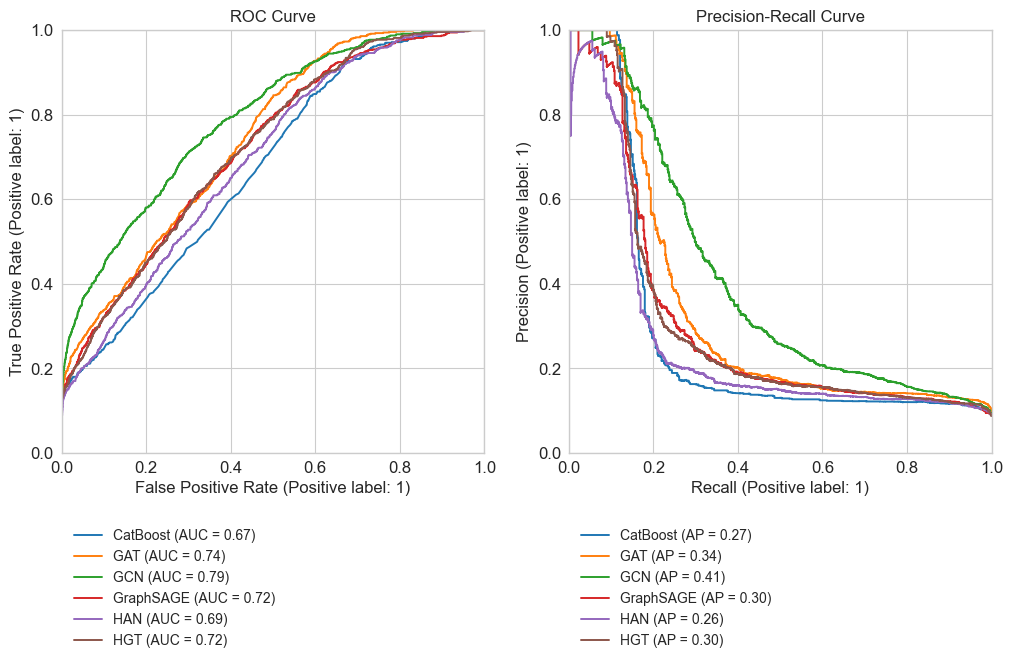

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for model_name in sorted(prediction_dict.keys()):
    preds = prediction_dict[model_name]
    plot_roc_curve(axes[0], preds, model_name)
    plot_pr_curve(axes[1], preds, model_name)

axes[0].legend(loc="upper left", bbox_to_anchor=(0, -0.15))
axes[1].legend(loc="upper left", bbox_to_anchor=(0, -0.15))

fig.savefig("figures/roc-pr-curve.png", dpi=300, bbox_inches="tight")

In [45]:
import math


def plot_confusion_matrix(ax, preds, label):
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=preds["actual"],
        y_pred=preds["pred_proba"] >= 0.5,
        ax=ax,
    )
    ax.set_title(label)


def plot_confusion_matrices(preds_dict):
    fig, axes = plt.subplots(
        nrows=math.ceil(len(preds_dict) / 2), ncols=2, figsize=(12, 6)
    )
    axes = np.ravel(axes)
    for i, (model_name, preds) in enumerate(preds_dict.items()):
        plot_confusion_matrix(axes[i], preds, model_name)
    # fig.tight_layout()
    fig.savefig("figures/confusion-matrices.png", dpi=300)


def get_classification_report(preds_dict):
    for model_name, preds in preds_dict.items():
        print(model_name)
        print(
            sklearn.metrics.classification_report(
                preds["actual"], preds["pred_proba"] >= 0.5
            )
        )
        print()

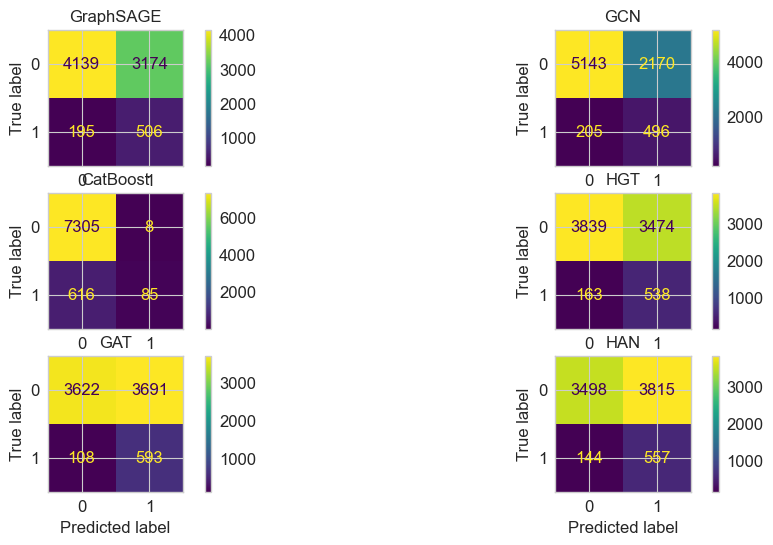

In [46]:
plot_confusion_matrices(prediction_dict)